In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
from salishsea_tools import viz_tools, geo_tools,nc_tools
from scipy.interpolate import griddata, interp1d
import matplotlib.cm as cm
import xarray as xr
from grid_alignment import calculate_initial_compass_bearing as cibc

In [2]:
path = '/home/ssahu/saurav/JP_BC/'

In [154]:
gridT = xr.open_dataset(path+'cat_42_days_T.nc')

In [155]:
gridT.coords

Coordinates:
  * deptht        (deptht) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
  * time_counter  (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bnds          (bnds) int64 0 1

In [156]:
gridT.dims

Frozen(SortedKeysDict({'deptht': 50, 'bnds': 2, 'time_counter': 43, 'x': 715, 'y': 1021}))

In [157]:
gridT.attrs

OrderedDict([('Conventions', 'CF-1.1'),
             ('CDI',
              'Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)'),
             ('history',
              'Wed Jul 27 13:01:08 2016: /usr/local/bin/ncrename -O -v lat,nav_lat -v lon,nav_lon /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc\nWed Jul 27 12:36:59 2016: cdo timmean /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/DIMG/NEP036-N30_CU60_20160401_20160332_00813600_grid_T_0000.nc /fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/WORKDIR_grid_T_00813600/timmean_grid_T_00813600_0000.nc'),
             ('file_name',
              '/fs/peg/data/rpne/rpnejpp/NEP036/NEP036-N30-OUT/CDF_COMB/NEP036-N30_IN_20160401_00813600_grid_T.nc'),
             ('production', 'An IPSL model'),
             ('TimeStamp', '2016-JUL-27 10:02:26 GMT-0000'),
             ('CDO',
              'Climate Data Operators version 1.7.1 (http://mpimet.mpg.de/cdo)')])

In [158]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [159]:
ssh = np.array(gridT['sossheig'][:,55:400,446:701]);
votemper = np.array(gridT['votemper'][:,:,55:400,446:701]);
vosaline = np.array(gridT['vosaline'][:,:,55:400,446:701])
glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);


In [160]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

In [161]:
with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 

In [162]:
votemper.shape

(43, 50, 345, 255)

In [163]:
glamt_bc_JP.shape

(345, 255)

In [164]:
np.min(gphit_wcvi)

46.113550613066906

In [165]:
np.min(np.array(gphit_bc_JP))

45.213524

In [166]:
(Nx,Ny) = gphit_wcvi.shape

In [15]:
X = glamt_bc_JP.flatten()

Y = gphit_bc_JP.flatten()

points = (X[:],Y[:])

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];
glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];


xi_left = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten());
xi_right = (glamt_wcvi_bc_right.flatten(), gphit_wcvi_bc_right.flatten());

#votemper_wcvi = np.zeros((43,50,Nx,Ny));

votemper_wcvi_left = np.zeros((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
votemper_wcvi_right = np.zeros((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));

ssh_wcvi_left = np.zeros((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));


for p,q in enumerate(votemper_wcvi_left[:,...]):
    for i,j in enumerate(votemper_wcvi_left[p,:,...]):
        votemper_wcvi_left[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        votemper_wcvi_right[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)
#        vosaline_wcvi[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi, method= 'linear', glamt_wcvi.shape))

#vosaline_wcvi = np.reshape(griddata(points, vosaline.flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [17]:
votemper_wcvi_left.shape

(43, 50, 100, 4)

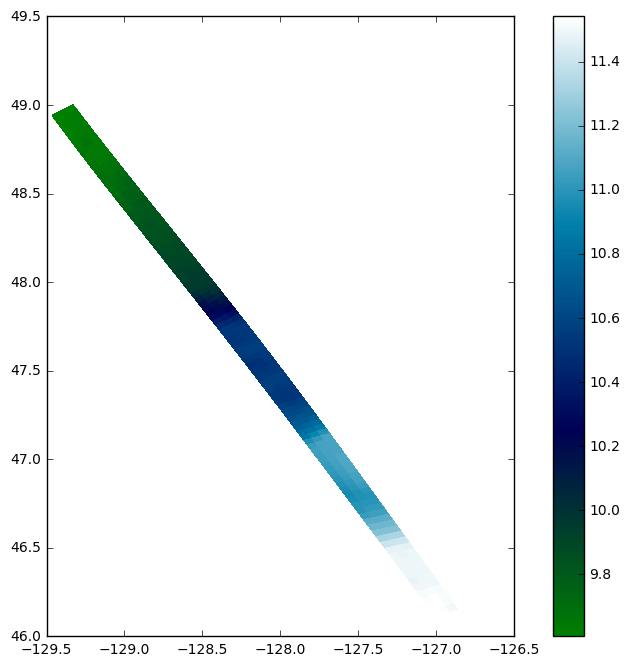

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],votemper_wcvi_left[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

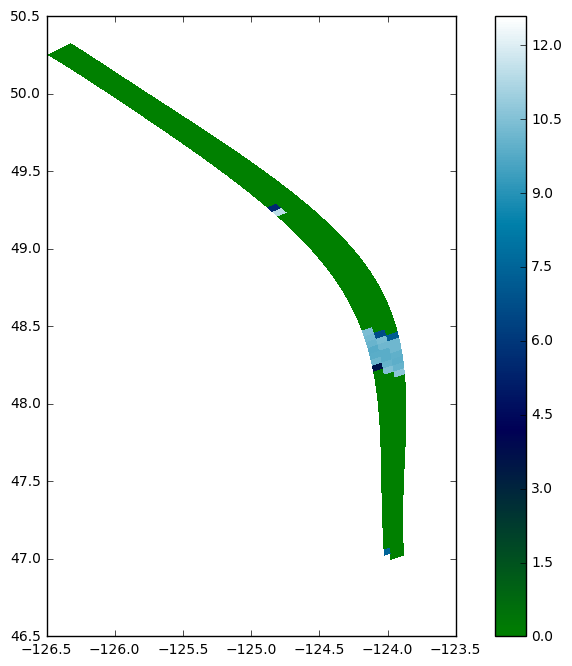

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],votemper_wcvi_right[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [28]:
np.save('votemper_leftbc', votemper_wcvi_left)

In [29]:
np.save('votemper_rightbc', votemper_wcvi_right)

In [30]:
#Now for Salinity


#votemper_wcvi = np.zeros((43,50,Nx,Ny));

vosaline_wcvi_left = np.zeros((43,50,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));
vosaline_wcvi_right = np.zeros((43,50,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));



for p,q in enumerate(vosaline_wcvi_left[:,...]):
    for i,j in enumerate(vosaline_wcvi_left[p,:,...]):
        vosaline_wcvi_left[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
        vosaline_wcvi_right[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)



In [32]:
np.save('vosaline_leftbc', vosaline_wcvi_left);
np.save('vosaline_rightbc', vosaline_wcvi_right);

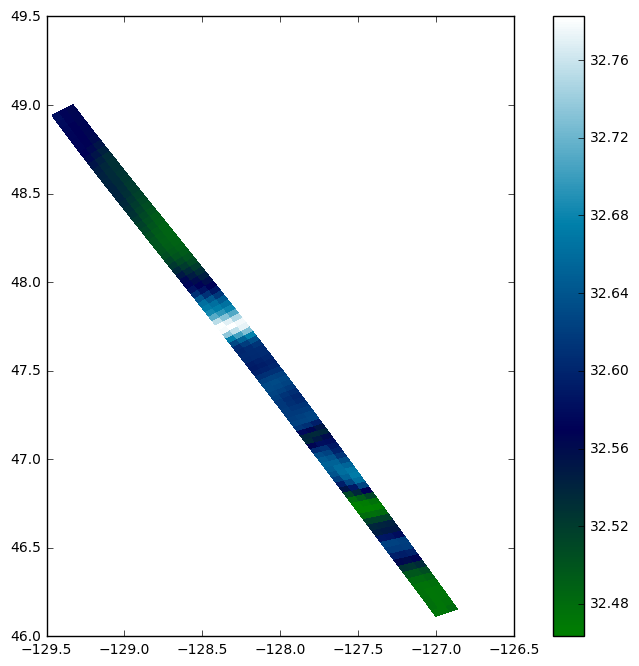

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],vosaline_wcvi_left[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

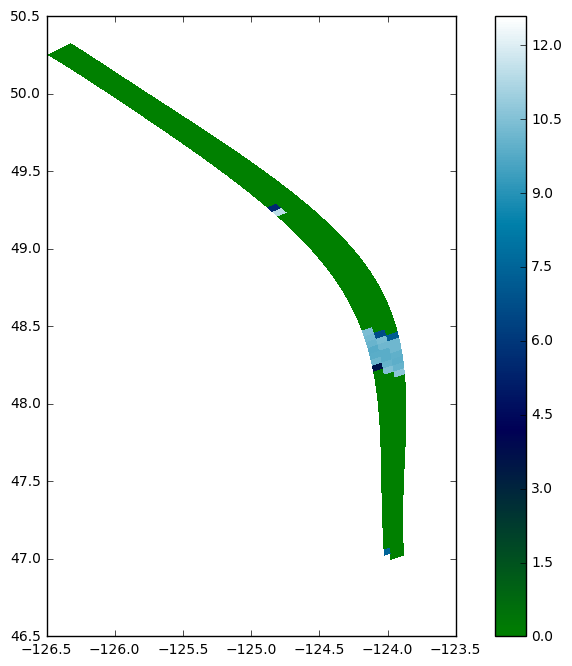

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],votemper_wcvi_right[0,0,:], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [137]:
ssh_wcvi = np.zeros((43,Nx,Ny))
for i,j in enumerate(ssh[:,...]):
    ssh_wcvi[i,...] = np.reshape(griddata(points, ssh[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)

KeyboardInterrupt: 

In [126]:
votemper_wcvi.shape

(43, 50, 100, 70)

In [128]:
glamt_wcvi.shape

(100, 70)

In [37]:
#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_left = glamt_wcvi[:,0:N-1]; gphit_wcvi_bc_left = gphit_wcvi[:,0:N-1];

glamt_wcvi_bc_right = glamt_wcvi[:,-N:-1]; gphit_wcvi_bc_right = gphit_wcvi[:,-N:-1];

xi = (glamt_wcvi_bc_left.flatten(), gphit_wcvi_bc_left.flatten())

ssh_wcvi_left = np.zeros((43,glamt_wcvi_bc_left.shape[0], glamt_wcvi_bc_left.shape[1]));

ssh_wcvi_right = np.zeros((43,glamt_wcvi_bc_right.shape[0], glamt_wcvi_bc_right.shape[1]));

for i,j in enumerate(ssh_wcvi_left[:,...]):
    ssh_wcvi_left[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_left, method= 'linear'), glamt_wcvi_bc_left.shape)
    ssh_wcvi_right[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_right, method= 'linear'), glamt_wcvi_bc_right.shape)

    
print(glamt_wcvi_bc_right.shape, ssh_wcvi_left.shape)

(100, 4) (43, 100, 4)


In [39]:
np.save('ssh_leftbc', ssh_wcvi_left);
np.save('ssh_rightbc', ssh_wcvi_right)

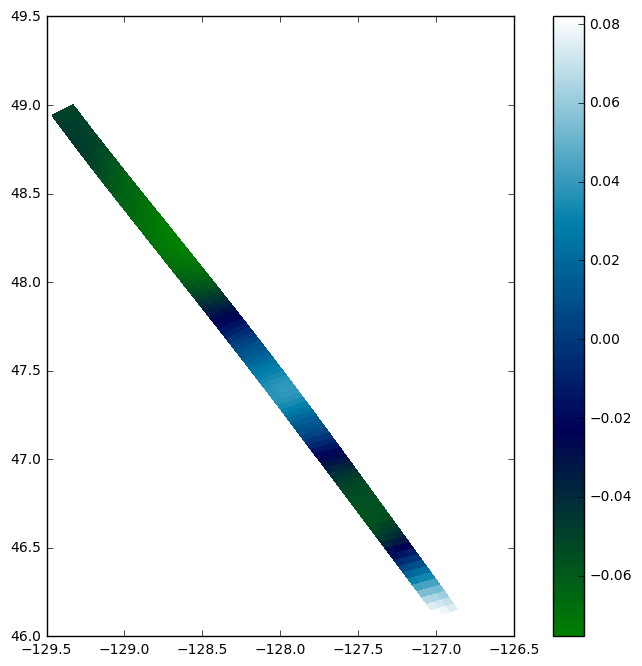

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],ssh_wcvi_left[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

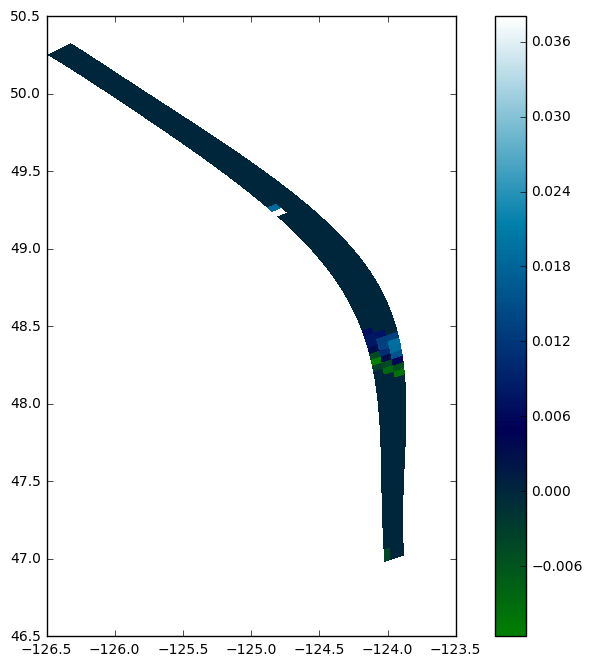

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_right[:], gphit_wcvi_bc_right[:],ssh_wcvi_right[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [50]:
N = 5

glamt_wcvi_bc_bottom = glamt_wcvi[0:N-1,:]; gphit_wcvi_bc_bottom = gphit_wcvi[0:N-1,:];

glamt_wcvi_bc_top = glamt_wcvi[-N:-1,:]; gphit_wcvi_bc_top = gphit_wcvi[-N:-1,:];

xi_top = (glamt_wcvi_bc_top.flatten(), gphit_wcvi_bc_top.flatten());
xi_bottom = (glamt_wcvi_bc_bottom.flatten(), gphit_wcvi_bc_bottom.flatten());

ssh_wcvi_top = np.zeros((43,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));

ssh_wcvi_bottom = np.zeros((43,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));

for i,j in enumerate(ssh_wcvi_top[:,...]):
    ssh_wcvi_top[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
    ssh_wcvi_bottom[i,...] = np.reshape(griddata(points, np.array(ssh[i,...]).flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

    
print(glamt_wcvi_bc_top.shape, ssh_wcvi_top.shape)

(4, 70) (43, 4, 70)


In [51]:
np.save('ssh_topbc', ssh_wcvi_top);
np.save('ssh_bottombc', ssh_wcvi_bottom)

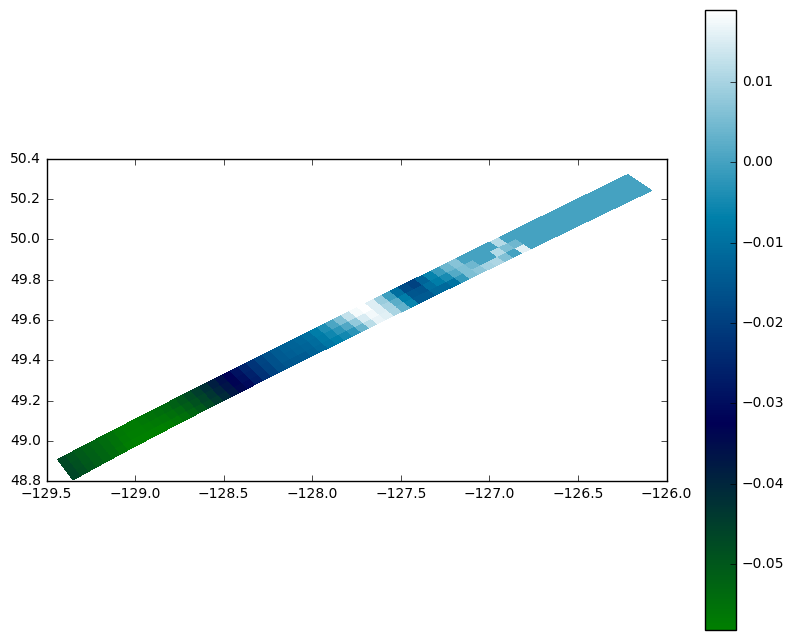

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], ssh_wcvi_top[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:],ssh_wcvi_bottom[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

NameError: name 'glamt_wcvi_bc_bottom' is not defined

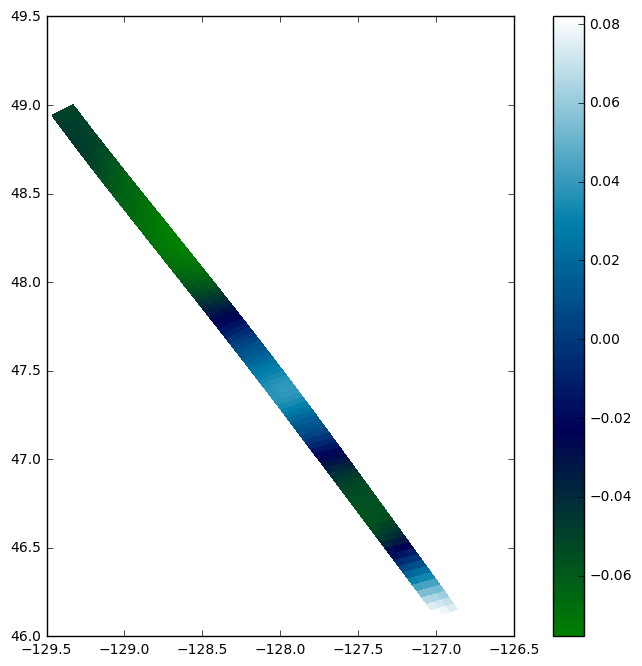

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_left[:], gphit_wcvi_bc_left[:],ssh_wcvi_left[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

#### Next we would like to interpolate the values of JP to the outer say 5 grid point cells of our domain based on  matching the lats and lons of JP with our domain

In [120]:
for idx, val in enumerate(votemper_wcvi[0,:,...]):
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [14]:
np.array(ssh)

array([[[  0.00000000e+00,  -1.86861958e-02,  -1.34836314e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.86861958e-02,  -1.86861958e-02,  -1.34836314e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.86894257e-02,  -1.86894257e-02,  -2.90848408e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   6.79792762e-02,   7.52824321e-02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  6.79792762e-02,   6.79792762e-02,   7.52824321e-0

In [16]:
ssh.shape

(43, 1021, 715)

#### Remaining work
    1) Interpolate to our WCVI grid points of T, S and SSH first 
     2) Slice our domain to keep those variables only for the boundary points (strip of 5 data points on the outer boundary)
     3) Use the filter on the surface T and S points after having sliced them
     4) Do the rotation thingy on U and V points only for the stripped domain (get glamu and gphiu for wcvi and have them on those points
     5) Write a boundary condition file (4 Files one for each boundary) (2D and 3D separately)

In [ ]:
#open saved np arrays



In [167]:
X = glamt_bc_JP.flatten()

Y = gphit_bc_JP.flatten()

points = (X[:],Y[:])


#Number of points to trim off the ends

N = 5

glamt_wcvi_bc_bottom = glamt_wcvi[0:N-1,:]; gphit_wcvi_bc_bottom = gphit_wcvi[0:N-1,:];

glamt_wcvi_bc_top = glamt_wcvi[-N:-1,:]; gphit_wcvi_bc_top = gphit_wcvi[-N:-1,:];

xi_top = (glamt_wcvi_bc_top.flatten(), gphit_wcvi_bc_top.flatten());
xi_bottom = (glamt_wcvi_bc_bottom.flatten(), gphit_wcvi_bc_bottom.flatten());
#votemper_wcvi = np.zeros((43,50,Nx,Ny));

votemper_wcvi_top = np.zeros((43,50,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));
votemper_wcvi_bottom = np.zeros((43,50,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));

vosaline_wcvi_top = np.zeros((43,50,glamt_wcvi_bc_top.shape[0], glamt_wcvi_bc_top.shape[1]));
vosaline_wcvi_bottom = np.zeros((43,50,glamt_wcvi_bc_bottom.shape[0], glamt_wcvi_bc_bottom.shape[1]));



for p,q in enumerate(votemper_wcvi_top[:,...]):
    for i,j in enumerate(votemper_wcvi_top[p,:,...]):
        votemper_wcvi_top[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
        votemper_wcvi_bottom[p,i,...] = np.reshape(griddata(points, votemper[p,i,...].flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

        vosaline_wcvi_top[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_top, method= 'linear'), glamt_wcvi_bc_top.shape)
        vosaline_wcvi_bottom[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi_bottom, method= 'linear'), glamt_wcvi_bc_bottom.shape)

        
        #        vosaline_wcvi[p,i,...] = np.reshape(griddata(points, vosaline[p,i,...].flatten(), xi, method= 'linear', glamt_wcvi.shape))

#vosaline_wcvi = np.reshape(griddata(points, vosaline.flatten(), xi, method= 'linear'), glamt_wcvi.shape)

In [168]:
np.save('votemper_topbc', votemper_wcvi_top); np.save('votemper_bottombc', votemper_wcvi_bottom);
np.save('vosaline_topbc', vosaline_wcvi_top); np.save('vosaline_bottombc', vosaline_wcvi_bottom);

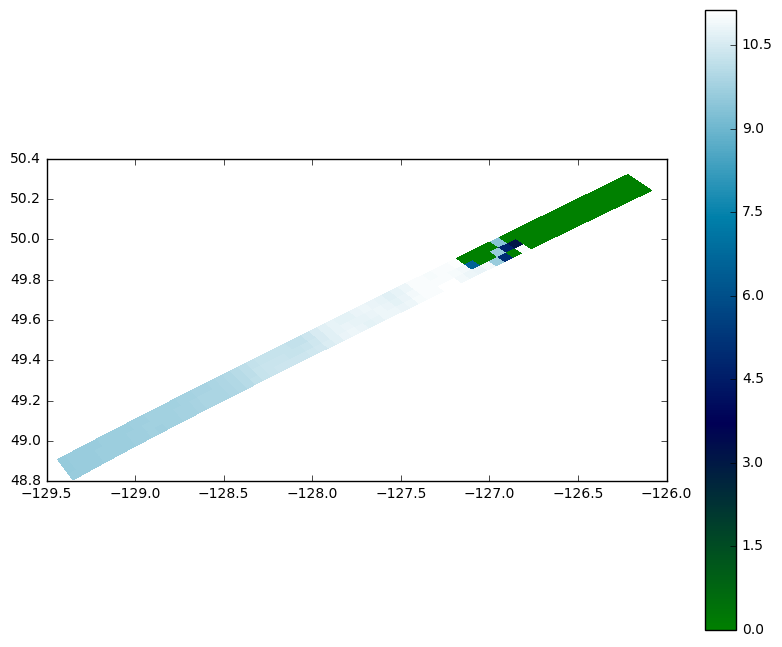

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], votemper_wcvi_top[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

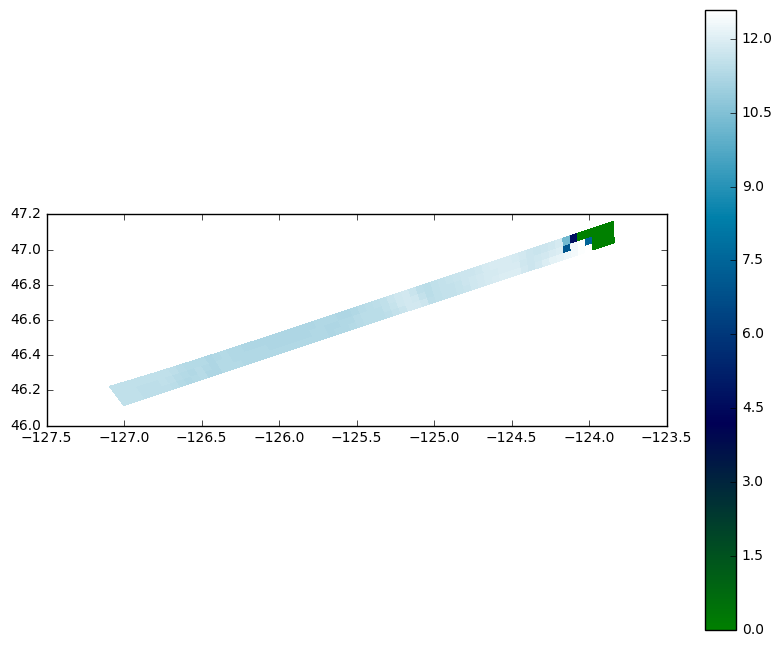

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:], votemper_wcvi_bottom[0,0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

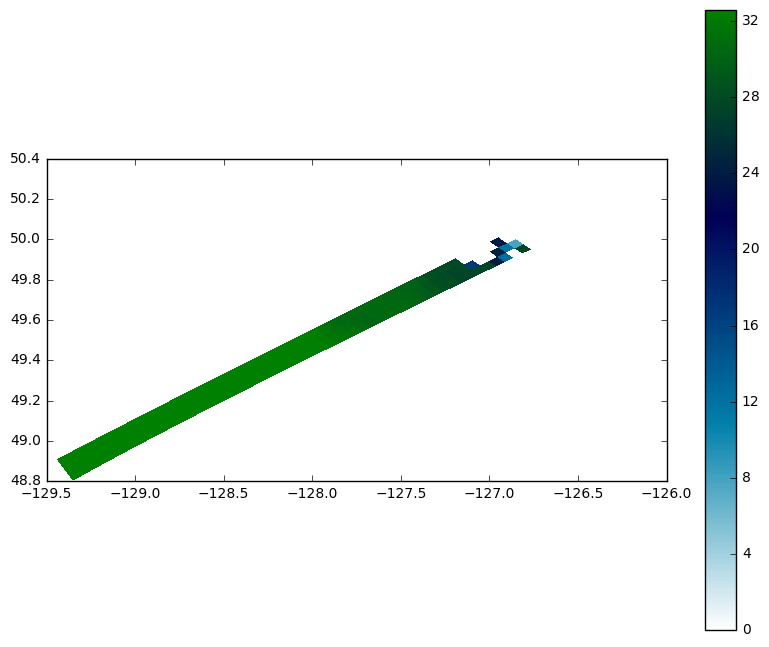

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_top[:], gphit_wcvi_bc_top[:], vosaline_wcvi_top[0,0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

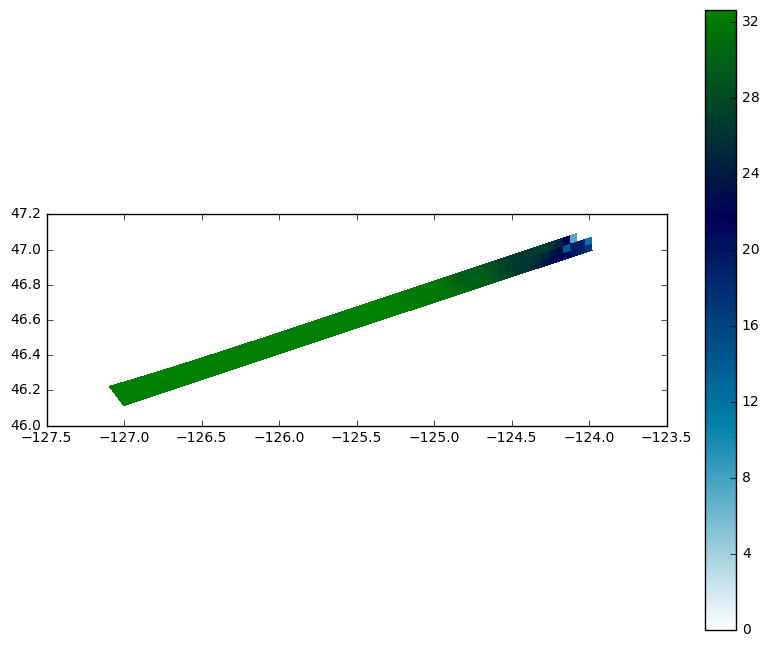

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi_bc_bottom[:], gphit_wcvi_bc_bottom[:], vosaline_wcvi_bottom[0,0,...], cmap =cm.ocean_r)
fig.colorbar(mesh)
plt.show()

In [178]:
!ls

bathy_meter.nc			      ssh_rightbc.npy
C:\nppdf32Log\debuglog.txt	      ssh_topbc.npy
coordinates.nc			      vosaline_bottombc.npy
Detiding.ipynb			      vosaline_leftbc.npy
grid_alignment.py		      vosaline_rightbc.npy
Grid_transformation.ipynb	      vosaline_topbc.npy
JP_Grid.png			      votemper_bottombc.npy
Making_lateral_boundaries.ipynb       votemper_leftbc.npy
Plotting_data_over_3_locations.ipynb  votemper_rightbc.npy
__pycache__			      votemper_topbc.npy
ssh_bottombc.npy		      WCVI_Grid.png
ssh_leftbc.npy			      WCVI_orthogonality.png


In [16]:
fname_U_BC = 'cat_43_U.nc'; fname_V_BC = 'cat_43_V.nc';

In [17]:
gridU = xr.open_dataset(path+ fname_U_BC);
gridV = xr.open_dataset(path+ fname_V_BC);



In [18]:
gridU.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, depthu: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * depthu             (depthu) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.269 -142.241 -142.213 -142.186 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    vozocrtx           (time_counter, depthu, y, x) float64 0.0 0.06092 ...
    sozotaux           (time_counter, y, x) float64 0.0 0.01107 0.01111 ...
Attributes:
    Conventions: CF-1.1
    CDI: Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)

In [19]:
gridU.coords

Coordinates:
  * depthu        (depthu) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
  * time_counter  (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bnds          (bnds) int64 0 1

In [20]:
gridU.dims

Frozen(SortedKeysDict({'bnds': 2, 'x': 715, 'y': 1021, 'time_counter': 43, 'depthu': 50}))

In [21]:
gridV.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, depthv: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * depthv             (depthv) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0573 45.0561 45.0549 45.0537 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    vomecrty           (time_counter, depthv, y, x) float64 0.0 0.09244 ...
    sometauy           (time_counter, y, x) float64 0.0 0.01886 0.01835 ...
Attributes:
    Conventions: CF-1.1
    CDI: Climate Data Interface version 1.7.1 (http://mpimet.mpg.de/cdi)
 

In [22]:
#nav_lon_T = np.array(gridT['nav_lon'][55:400,446:701]);
#nav_lat_T = np.array(gridT['nav_lat'][55:400,446:701]);

nav_lon_U = np.array(gridU['nav_lon'][55:400,446:701]);
nav_lat_U = np.array(gridU['nav_lat'][55:400,446:701]);

nav_lon_V = np.array(gridV['nav_lon'][55:400,446:701]);
nav_lat_V = np.array(gridV['nav_lat'][55:400,446:701]); 

U_vel_BC = np.array(gridU['vozocrtx'][:,:,55:400,446:701]);
V_vel_BC = np.array(gridV['vomecrty'][:,:,55:400,446:701]);


#votemper = np.array(gridT['votemper'][:,:,55:400,446:701]);
#vosaline = np.array(gridT['vosaline'][:,:,55:400,446:701])
#glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
#gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);

In [23]:
fname_mask = 'mesh_mask.nc'
mask = xr.open_dataset(path+ fname_mask)


In [24]:
mask.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:       (t: 1, x: 715, y: 1021, z: 50)
Coordinates:
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * z             (z) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * t             (t) int64 0
Data variables:
    nav_lon       (y, x) float32 -142.283 -142.256 -142.228 -142.2 -142.173 ...
    nav_lat       (y, x) float32 45.0491 45.0479 45.0467 45.0456 45.0444 ...
    nav_lev       (z) float32 0.494025 1.54138 2.64567 3.81949 5.07822 ...
    time_counter  (t) float64 0.0
    tmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    umask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    vmask         (t, z, y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    fmask         (t, z, y, x) int8 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    tmaskutil     (t, 

In [25]:
nav_lon_T.shape


NameError: name 'nav_lon_T' is not defined

In [26]:
t_mask = mask['tmask'][0,:,55:400,446:701];

for i,j in enumerate (U_vel_BC[:,...]):
    U_vel_BC[i,...] = ma.masked_array(U_vel_BC[i,...], mask = 1- t_mask[...])
    V_vel_BC[i,...] = ma.masked_array(V_vel_BC[i, ...], mask = 1- t_mask[...])
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_vel_BC_tzyx, v_vel_BC_tzyx = viz_tools.unstagger(U_vel_BC, V_vel_BC)

mag_vel_BC = np.sqrt(np.multiply(u_vel_BC_tzyx,u_vel_BC_tzyx), np.multiply(v_vel_BC_tzyx,v_vel_BC_tzyx));
ang_vel_BC = np.degrees(np.arctan2(v_vel_BC_tzyx, u_vel_BC_tzyx));







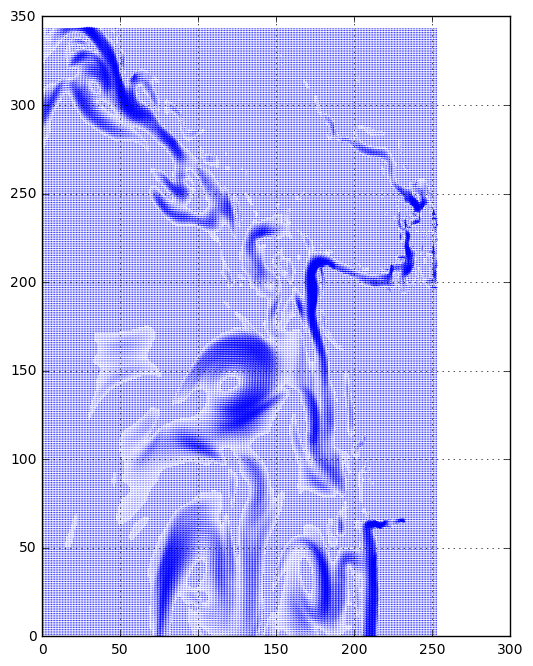

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(u_vel_BC_tzyx[0,0,...], v_vel_BC_tzyx[0,0,...], color='blue', pivot='mid')
ax.grid()

plt.show()


In [28]:
fname_coord = 'coordinates.nc'


grid_BC = xr.open_dataset(path+ fname_coord);

In [29]:
grid_BC.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:  (x: 715, y: 1021)
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    nav_lon  (y, x) float32 -142.283 -142.256 -142.228 -142.2 -142.173 ...
    nav_lat  (y, x) float32 45.0491 45.0479 45.0467 45.0456 45.0444 45.0432 ...
    glamt    (y, x) float64 -142.3 -142.3 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamu    (y, x) float64 -142.3 -142.2 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamv    (y, x) float64 -142.3 -142.3 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    glamf    (y, x) float64 -142.3 -142.2 -142.2 -142.2 -142.2 -142.1 -142.1 ...
    gphit    (y, x) float64 45.05 45.05 45.05 45.05 45.04 45.04 45.04 45.04 ...
    gphiu    (y, x) float64 45.05 45.05 45.05 45.05 45.04 45.04 45.04 45.04 ...
    gphiv    (y, x) float64 45.06 45.06 45.05 45.05 45.05 45.05 45.05 45.05 ...
    gphif    (

In [3]:
fname_coord_BC = 'coordinates.nc'

grid_JP = xr.open_dataset(path+ fname_coord_BC);
glamt = grid_JP.variables['glamt'][55:400,446:701]; gphit = grid_JP.variables['gphit'][55:400,446:701];
glamu = grid_JP.variables['glamu'][55:400,446:701]; gphiu = grid_JP.variables['gphiu'][55:400,446:701];
glamv = grid_JP.variables['glamv'][55:400,446:701]; gphiv = grid_JP.variables['gphiv'][55:400,446:701];


# First point
lonA = glamu[:,0:-1]
latA = gphiu[:,0:-1]
# Second point
lonB = glamu[:,1:]
latB = gphiu[:,1:]


bearing = cibc((latA,lonA),(latB,lonB))
angle_needed = 90 - bearing;

In [31]:
bearing.shape, glamt.shape ,gphit.shape

((345, 254), (345, 255), (345, 255))

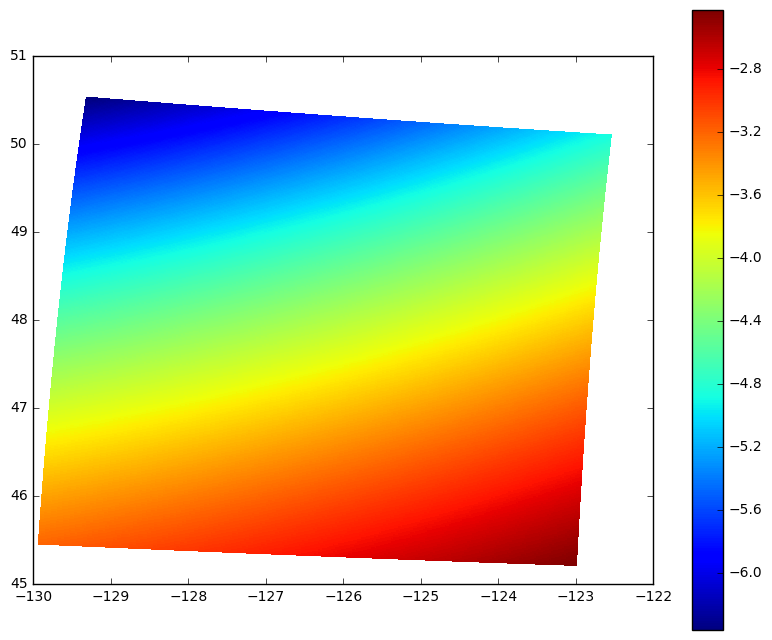

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(glamt, gphit, angle_needed)
fig.colorbar(mesh)
plt.show()

In [33]:
u_vel_BC_tzyx.shape

(43, 50, 344, 254)

In [34]:
angle_unrotated = np.zeros((ang_vel_BC.shape[0],ang_vel_BC.shape[1],ang_vel_BC.shape[2], ang_vel_BC.shape[3]));


for p,q in enumerate(ang_vel_BC[:,...]):
    for i,j in enumerate(ang_vel_BC[p,:,...]):
        angle_unrotated[p,i,...] = ang_vel_BC[p,i,...] + angle_needed[1:,:];
                                
                                
u_unrotated = mag_vel_BC*np.cos(np.radians(angle_unrotated));
v_unrotated = mag_vel_BC*np.sin(np.radians(angle_unrotated));

                                


In [4]:
fname_coord_WCVI = 'coordinates_wcvi.nc';

with nc.Dataset(path+fname_coord_WCVI, 'r') as grid_WCVI:
    glamt_wcvi = grid_WCVI.variables['glamt'][0,:]; gphit_wcvi = grid_WCVI.variables['gphit'][0,:];
    glamu_wcvi = grid_WCVI.variables['glamu'][0,:]; gphiu_wcvi = grid_WCVI.variables['gphiu'][0,:];
    glamv_wcvi = grid_WCVI.variables['glamv'][0,:]; gphiv_wcvi = grid_WCVI.variables['gphiv'][0,:];
    
    
# First point
lonA_wcvi = glamu_wcvi[:,0:-1]
latA_wcvi = gphiu_wcvi[:,0:-1]
# Second point
lonB_wcvi = glamu_wcvi[:,1:]
latB_wcvi = gphiu_wcvi[:,1:]


bearing_wcvi = cibc((latA_wcvi,lonA_wcvi),(latB_wcvi,lonB_wcvi));
angle_needed_wcvi = 90 - bearing_wcvi;


In [36]:
angle_needed_wcvi.shape

(100, 69)

In [37]:
glamt_cut_JP = glamt[1:,1:]; gphit_cut_JP = gphit[1:,1:];

X = np.array(glamt_cut_JP).flatten(); Y = np.array(gphit_cut_JP).flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

u_unrotated_wcvi_t = np.zeros((u_unrotated.shape[0],u_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
v_unrotated_wcvi_t = np.zeros((v_unrotated.shape[0],v_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

#for p,q in enumerate(u_unrotated[:,...]):
#    for i,j in enumerate(u_unrotated[p,:,...]):
#        u_unrotated_wcvi_t[p,i,...] = griddata(points, u_unrotated[p,i,...].flatten(), xi, method= 'linear')
#        v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
for p,q in enumerate(u_unrotated[:,...]):
    for i,j in enumerate(v_unrotated[p,:,...]):
        u_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), \
                                                 xi, method= 'linear'), glamt_wcvi.shape)
        v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), \
                                                 xi, method= 'linear'), glamt_wcvi.shape)
#u_unrotated_wcvi_t = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
#v_unrotated_wcvi_t = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)

np.save('u_unrotated_wcvi_t_3D', u_unrotated_wcvi_t);
np.save('v_unrotated_wcvi_t_3D', v_unrotated_wcvi_t);

In [5]:
u_unrotated_wcvi_t = np.load('u_unrotated_wcvi_t_3D.npy'); v_unrotated_wcvi_t = np.load('v_unrotated_wcvi_t_3D.npy');

In [12]:
mag_vel_at_wcvi = np.sqrt(np.multiply(u_unrotated_wcvi_t,u_unrotated_wcvi_t), \
                          np.multiply(v_unrotated_wcvi_t,v_unrotated_wcvi_t));
ang_vel_at_wcvi = np.degrees(np.arctan2(v_unrotated_wcvi_t, u_unrotated_wcvi_t));

angle_unrotated_wcvi = ang_vel_at_wcvi[...,:,1:] - angle_needed_wcvi;

u_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.cos(np.radians(angle_unrotated_wcvi[...])));
v_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.sin(np.radians(angle_unrotated_wcvi[...])));

In [26]:
def stagger(ugrid, vgrid):
    u = np.add(ugrid[...,:-1], ugrid[...,1:]) / 2;
    v = np.add(vgrid[...,:-1, :], vgrid[...,1:, :]) / 2;
    return u[...,:, :], v[...,:, :]

In [30]:
u_rotated_WCVI, v_rotated_WCVI = stagger(u_unrotated_rotated_to_wcvi, v_unrotated_rotated_to_wcvi)

In [32]:
N = 5

U_wcvi_top = u_rotated_WCVI[...,-N:-1,:]; V_wcvi_top = v_rotated_WCVI[...,-N:-1,:];
U_wcvi_bottom = u_rotated_WCVI[...,0:N-1,:]; V_wcvi_bottom = v_rotated_WCVI[...,0:N-1,:];

np.save('U_3D_wcvi_top', U_wcvi_top);
np.save('V_3D_wcvi_top', V_wcvi_top);
np.save('U_3D_wcvi_bottom', U_wcvi_bottom);
np.save('V_3D_wcvi_bottom', V_wcvi_bottom);



In [33]:
!ls

bathy_meter.nc			      u_unrotated_wcvi_t_3D.npy
C:\nppdf32Log\debuglog.txt	      u_unrotated_wcvi_t.npy
coordinates.nc			      V_3D_wcvi_bottom.npy
Detiding.ipynb			      V_3D_wcvi_top.npy
grid_alignment.py		      vosaline_bottombc.npy
Grid_transformation.ipynb	      vosaline_leftbc.npy
JP_Grid.png			      vosaline_rightbc.npy
Making_lateral_boundaries.ipynb       vosaline_topbc.npy
Plotting_data_over_3_locations.ipynb  votemper_bottombc.npy
__pycache__			      votemper_leftbc.npy
ssh_bottombc.npy		      votemper_rightbc.npy
ssh_leftbc.npy			      votemper_topbc.npy
ssh_rightbc.npy			      v_unrotated_wcvi_t_3D.npy
ssh_topbc.npy			      v_unrotated_wcvi_t.npy
U_3D_wcvi_bottom.npy		      WCVI_Grid.png
U_3D_wcvi_top.npy		      WCVI_orthogonality.png


In [29]:
ang_vel_at_wcvi.shape, angle_needed_wcvi.shape, angle_unrotated_wcvi.shape, u_rotated_WCVI.shape, v_rotated_WCVI.shape

((43, 50, 100, 70),
 (100, 69),
 (43, 50, 100, 69),
 (43, 50, 100, 68),
 (43, 50, 99, 69))

In [39]:
v_unrotated_wcvi_t.shape

(43, 50, 100, 70)

In [22]:
u_rotated_WCVI.shape

(43, 50, 100, 68)

In [34]:
U_wcvi_bottom.shape

(43, 50, 4, 68)

In [378]:
u_unrotated_wcvi_t.shape

(100, 70)

In [364]:
glamt_wcvi.shape

(100, 70)

In [369]:
Y.shape

(87376,)

In [210]:
U_vel_BC.shape

(43, 50, 1021, 715)

In [200]:
nav_lat_U.shape

(345, 255)

In [371]:
np.min(nav_lat_U)

45.213524

In [373]:
344*254

87376

In [375]:
X.shape

(87376,)

In [ ]:
votemper, vosaline, nav_lon, nav_lat, time_counter_bnds, sossheig